!pip install medmnist

In [1]:
from tqdm import tqdm
import numpy as np
import os
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

c:\Users\marus\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\marus\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
c:\Users\marus\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


# Let's use 3 2D models for a 3D dataset with size 28x28x28

In [121]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download)
test_dataset = DataClass(split='test', download=download)

100%|██████████| 32657349/32657349 [00:42<00:00, 774260.62it/s] 


Using downloaded and verified file: C:\Users\marus\.medmnist\organmnist3d.npz


In [122]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 28, 28, 28) (1,)


## Extract 2d slices

In [123]:
def extract_slices(data):
    axial_slices = []
    coronal_slices = []
    sagittal_slices = []
    targets = []

    for batch, target in data:
        image = batch[0]
        # Assuming image is a numpy array of shape (depth, height, width)
        # Extract the middle slice from each dimension
        axial_slices.append(image[image.shape[0] // 2, :, :][..., np.newaxis])
        coronal_slices.append(image[:, image.shape[1] // 2, :][..., np.newaxis])
        sagittal_slices.append(image[:, :, image.shape[2] // 2][..., np.newaxis])
        targets.append(target)

    return np.array(axial_slices, dtype='f'), np.array(coronal_slices, dtype='f'), np.array(sagittal_slices, dtype='f'), targets
    
train_axial_slices, train_coronal_slices, train_sagittal_slices, train_targets = extract_slices(train_dataset)
test_axial_slices, test_coronal_slices, test_sagittal_slices, test_targets = extract_slices(test_dataset)

In [124]:
train_axial_slices[..., -1].shape

(971, 28, 28)

In [125]:
class SliceDataset(data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        x = self.images[index]
        y = self.labels[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def montage(self, length=20, replace=False, save_folder='C:/Users/marus/Documents/dataset'):
        from medmnist.utils import montage2d

        n_sel = length * length
        sel = np.random.choice(self.__len__(), size=n_sel, replace=replace)

        montage_img = montage2d(imgs=(self.images[..., -1]*255).astype(np.uint8),
                                n_channels=n_channels,
                                sel=sel)
        
        if save_folder is not None:
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            montage_img.save(os.path.join(save_folder,
                                          f"{data_flag}_montage.png"))

        return montage_img

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_axial_dataset = SliceDataset(train_axial_slices, train_targets, transform=data_transform)
train_coronal_dataset = SliceDataset(train_coronal_slices, train_targets, transform=data_transform)
train_sagittal_dataset = SliceDataset(train_sagittal_slices, train_targets, transform=data_transform)

test_axial_dataset = SliceDataset(test_axial_slices, test_targets, transform=data_transform)
test_coronal_dataset = SliceDataset(test_coronal_slices, test_targets, transform=data_transform)
test_sagittal_dataset = SliceDataset(test_sagittal_slices, test_targets, transform=data_transform)

# And then data loaders
train_axial_loader = data.DataLoader(train_axial_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_coronal_loader = data.DataLoader(train_coronal_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_sagittal_loader = data.DataLoader(train_sagittal_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_axial_loader = data.DataLoader(test_axial_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_coronal_loader = data.DataLoader(test_coronal_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_sagittal_loader = data.DataLoader(test_sagittal_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [126]:
x, y = train_axial_dataset[0]

print(x.shape, y.shape)

torch.Size([1, 28, 28]) (1,)


In [127]:
for x, y in test_axial_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 28, 28]) torch.Size([128, 1])


### Let's see the images we chose

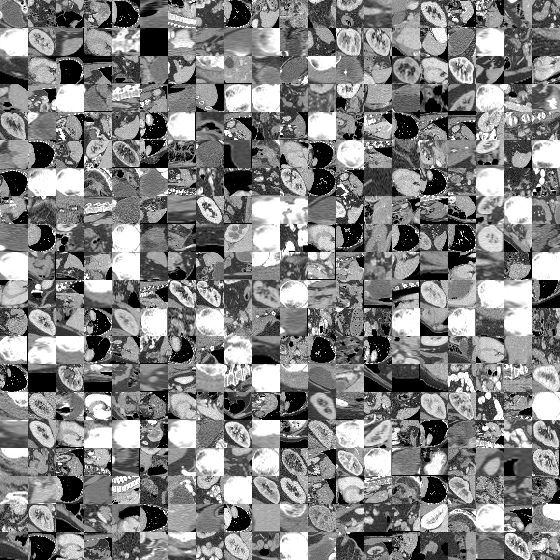

In [128]:
train_axial_dataset.montage()

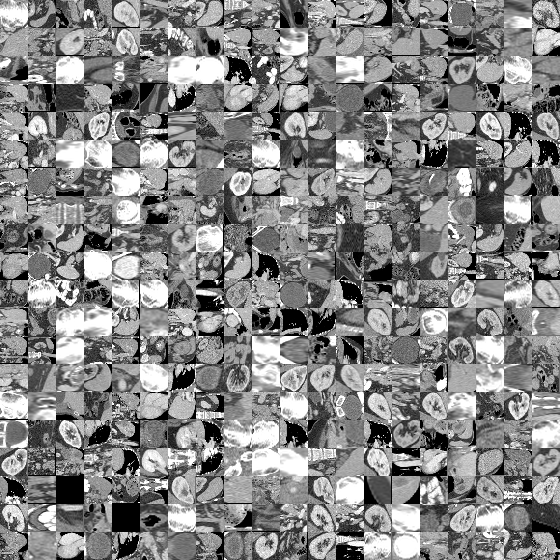

In [129]:
train_coronal_dataset.montage()

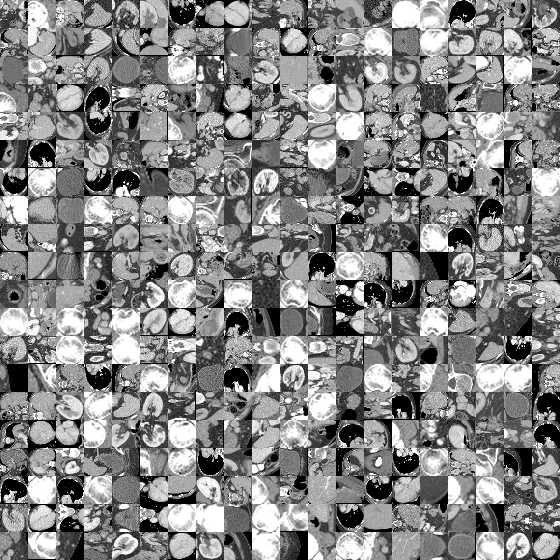

In [130]:
train_sagittal_dataset.montage()

## Training model

In [131]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [132]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_axial_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 8/8 [00:00<00:00, 10.46it/s]


In [133]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_axial_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test('test')

==> Evaluating ...
test  auc: 0.520  acc:0.113


## Repeat for all 3 directions

In [134]:
model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [135]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_coronal_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 8/8 [00:00<00:00,  9.32it/s]


In [136]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_coronal_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test('test')

==> Evaluating ...
test  auc: 0.491  acc:0.118


In [137]:
model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [138]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_sagittal_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 8/8 [00:00<00:00,  9.84it/s]


In [139]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_sagittal_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test('test')

==> Evaluating ...
test  auc: 0.469  acc:0.079


# Let's now work with a 3D dataset with size 64x64x64

In [140]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

100%|██████████| 361470105/361470105 [09:17<00:00, 648000.44it/s] 


Using downloaded and verified file: C:\Users\marus\.medmnist\organmnist3d_64.npz


In [141]:
print(info)

{'python_class': 'OrganMNIST3D', 'description': 'The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.', 'url': 'https://zenodo.org/records/10519652/files/organmnist3d.npz?download=1', 'MD5': 'a0c5a1ff56af4f155c46d46fbb45a2fe', 'url_64': 'https://zenodo.org/records/10519652/files/organmnist3d_64.npz?download=1', 'MD5_64': '58a2205adf14a9d0a189cb06dc78bf10', 'task': 'multi-class', 'label': {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancr

In [142]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: C:\Users\marus\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

In [143]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 64, 64, 64) (1,)


In [144]:
train_axial_slices, train_coronal_slices, train_sagittal_slices, train_targets = extract_slices(train_dataset)
test_axial_slices, test_coronal_slices, test_sagittal_slices, test_targets = extract_slices(test_dataset)

In [145]:
train_axial_slices.shape

(971, 64, 64, 1)

In [146]:
train_axial_dataset = SliceDataset(train_axial_slices, train_targets, transform=data_transform)
train_coronal_dataset = SliceDataset(train_coronal_slices, train_targets, transform=data_transform)
train_sagittal_dataset = SliceDataset(train_sagittal_slices, train_targets, transform=data_transform)

test_axial_dataset = SliceDataset(test_axial_slices, test_targets, transform=data_transform)
test_coronal_dataset = SliceDataset(test_coronal_slices, test_targets, transform=data_transform)
test_sagittal_dataset = SliceDataset(test_sagittal_slices, test_targets, transform=data_transform)

# And then data loaders
train_axial_loader = data.DataLoader(train_axial_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_coronal_loader = data.DataLoader(train_coronal_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_sagittal_loader = data.DataLoader(train_sagittal_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_axial_loader = data.DataLoader(test_axial_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_coronal_loader = data.DataLoader(test_coronal_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_sagittal_loader = data.DataLoader(test_sagittal_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [147]:
x, y = train_axial_dataset[0]

print(x.shape, y.shape)

torch.Size([1, 64, 64]) (1,)


In [148]:
for x, y in test_axial_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 64, 64]) torch.Size([128, 1])


### Let's see the images we chose

c:\Users\marus\anaconda3\lib\site-packages\medmnist\utils.py:32: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


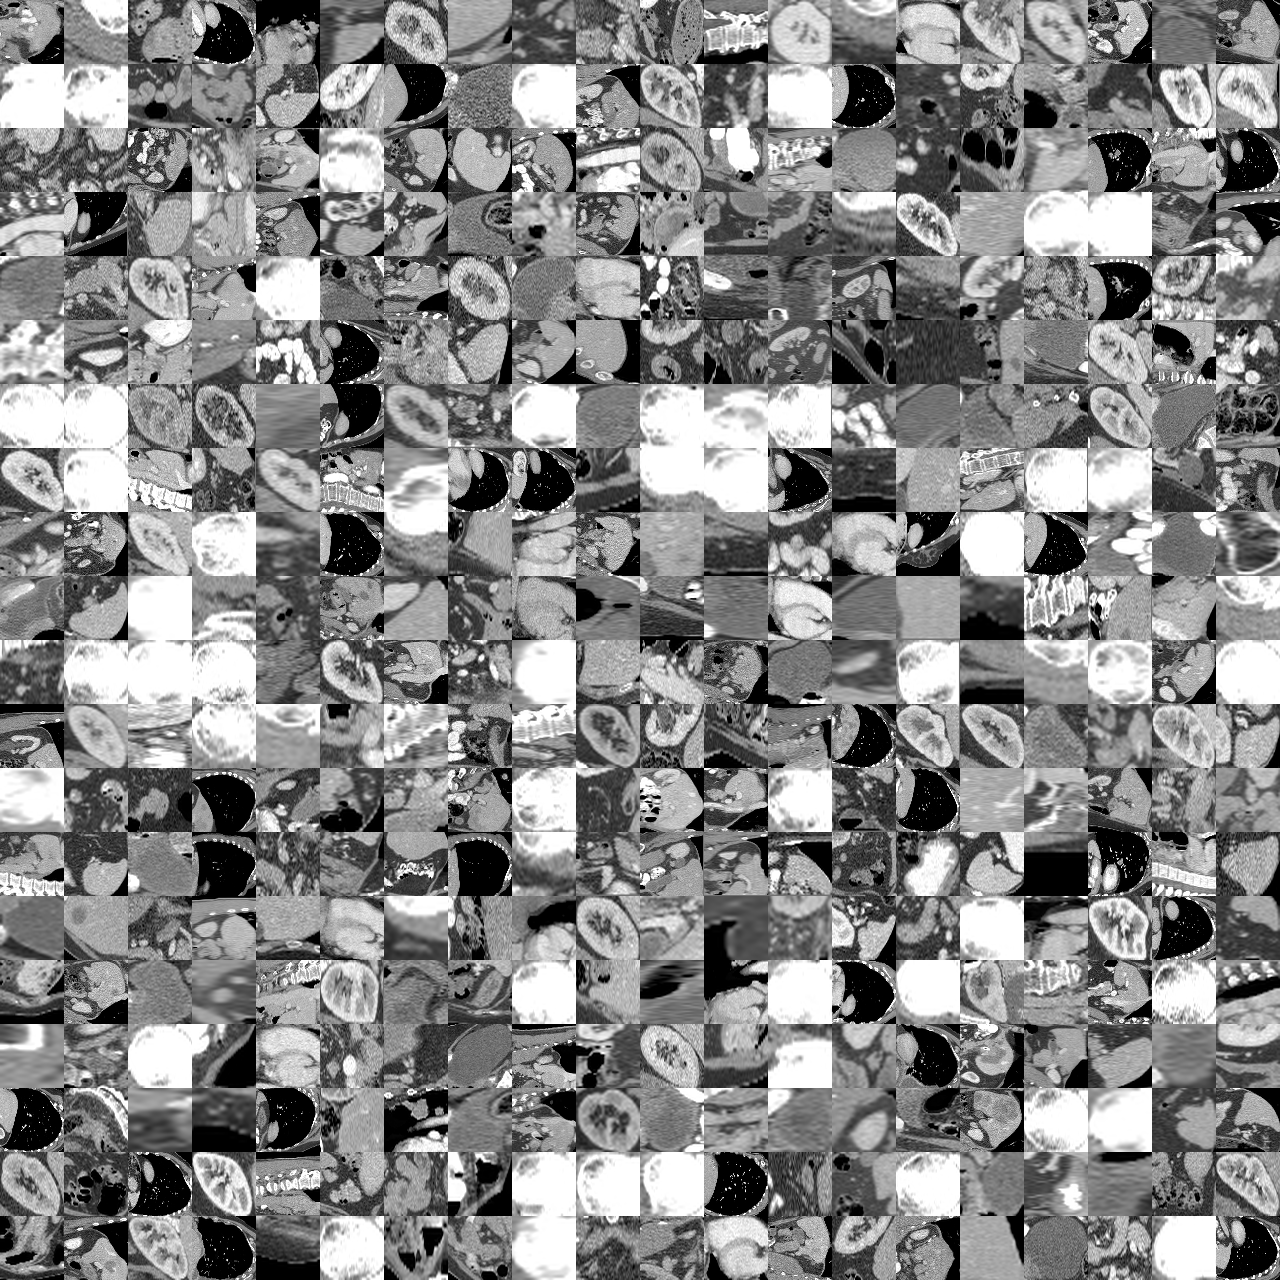

In [149]:
train_axial_dataset.montage()

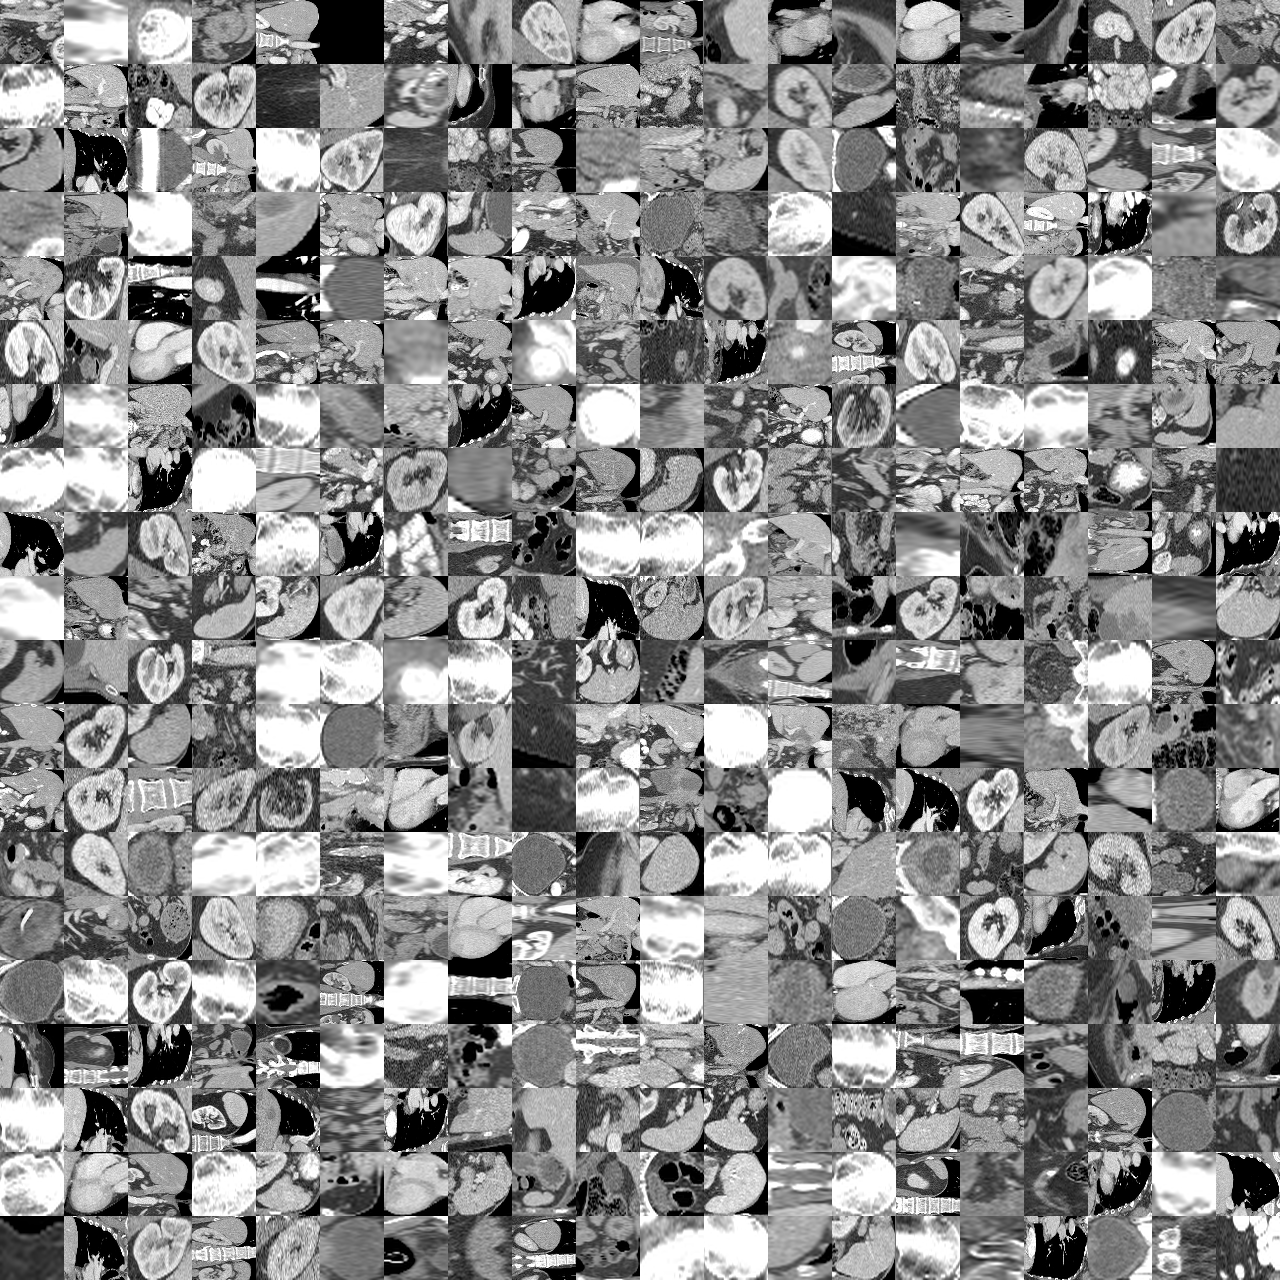

In [150]:
train_coronal_dataset.montage()

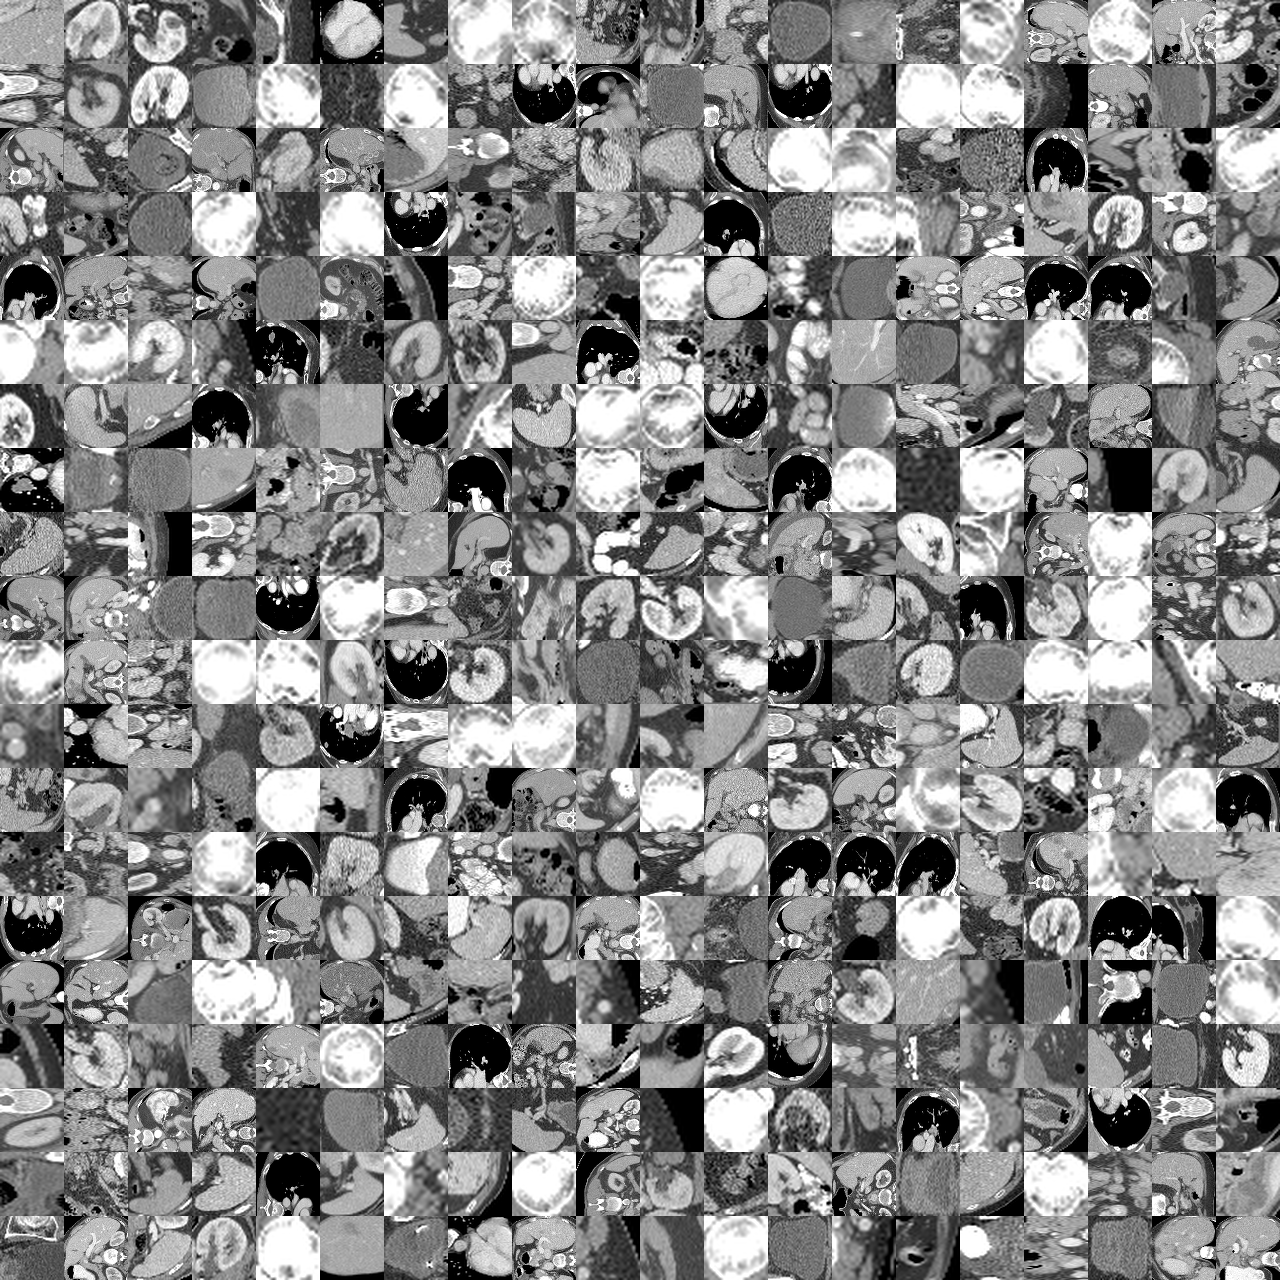

In [151]:
train_sagittal_dataset.montage()

In [235]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [236]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 3, stride = 2, padding = 1),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 1)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(4, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [237]:
model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=n_classes)

criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [238]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_axial_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:38<00:00,  4.83s/it]


In [239]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_axial_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test('test')

==> Evaluating ...
test  auc: 0.501  acc:0.108


## Repeat for all 3 directions

In [240]:
model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=n_classes)

criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [241]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_coronal_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:38<00:00,  4.84s/it]


In [242]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_coronal_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test('test')

==> Evaluating ...
test  auc: 0.483  acc:0.105


In [243]:
model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=n_classes)

criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [244]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_sagittal_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:39<00:00,  4.89s/it]


In [245]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_sagittal_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test('test')

==> Evaluating ...
test  auc: 0.503  acc:0.111
